# Huffman Coding 

#### Aim
To implement lossless image compression using Huffman Coding

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import heapq
import math
from dataclasses import dataclass

from rich.progress import Progress
import timeit

### Huffman Class 

In [4]:

class Node:
    def __init__(self,freq, symbol=None):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq
    
    def __gt__(self, other):
        return self.freq > other.freq
    
    def __repr__(self) -> str:
        return f"Node({self.symbol}-{self.freq})" if self.symbol is not None else f"Node({self.freq})"
    
@dataclass
class EncodedImage:
    shape: tuple
    bits: str
    tree: Node

    def __sizeof__(self) -> int:
        return self.bits.__sizeof__() + self.tree.__sizeof__()


def generate_tree(leaf_nodes):

    while len(leaf_nodes) > 1:
        left = heapq.heappop(leaf_nodes)
        right = heapq.heappop(leaf_nodes)
        parent = Node(left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(leaf_nodes, parent)
    
    return leaf_nodes[0]

def create_nodes(hist):
    # Normailized Frequency Table
    norm_freq = hist/ hist.sum()
    priority = np.argsort(norm_freq)
    freq_table = {
        k: norm_freq[k] for k in priority
    }
    assert norm_freq.max() == freq_table[priority[-1]]
    return list(
        filter( # Filter out zero frequency values
            lambda x: x.freq > 0,
            map(lambda x: Node( norm_freq[x], int(x)), priority)
        )
    )

def encode(img):
    hist, _ = np.histogram(img.flatten(), 256, [0, 256])
    # Create Nodes
    leaf_nodes = create_nodes(hist)
    # Create Min Heap
    heapq.heapify(leaf_nodes)
    # Generate Tree
    tree = generate_tree(leaf_nodes)
    # Create Encode Table
    encode_table = {}
    def traverse(node, code):
        if node is None:
            return
        if node.symbol is not None:
            encode_table[node.symbol] = code
            return
        traverse(node.left, code + '0')
        traverse(node.right, code + '1')

    traverse(tree, '')

    # Encode Image
    encoded_image = ""

    for pixel in img.flatten():
        encoded_image+=encode_table[pixel]

    return EncodedImage(img.shape, encoded_image, tree)
    

def decode(encoded: EncodedImage):
    
    bit_string = encoded.bits

    def traverse(node, code, offset):
        if code == "" or (node.left is None and node.right is None):
            return node.symbol, offset
        
        if code[0] == "0":
            return traverse(node.left, code[1:], offset+1)
        else:
            return traverse(node.right, code[1:], offset+1)
        
        
    offset = 0
    size = math.prod(encoded.shape)
    decoded = np.zeros(size, np.uint8)
    index = 0
    with Progress() as  pb:
        tk = pb.add_task("[green]Decoding...", total=size)
        while offset < len(bit_string):
            pixel, of = traverse(encoded.tree, bit_string[offset:], 0)
            decoded[index] = pixel
            index += 1
            offset += of            
            pb.advance(tk)
    decoded = decoded.reshape(encoded.shape)    

    return decoded

    

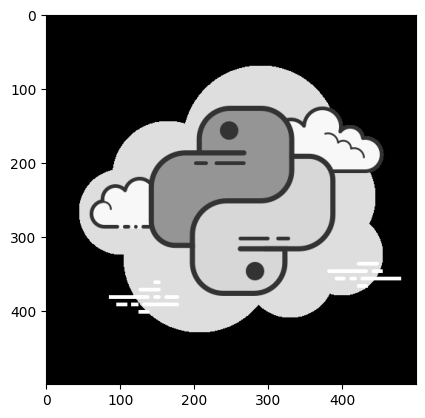

In [5]:
import urllib

req = urllib.request.urlretrieve("https://img.icons8.com/clouds/500/python.png", "dataset/imgs/python.png")

img = cv2.imread("dataset/imgs/python.png", 0)
plt.imshow(img, cmap="gray")

16.48177489999216

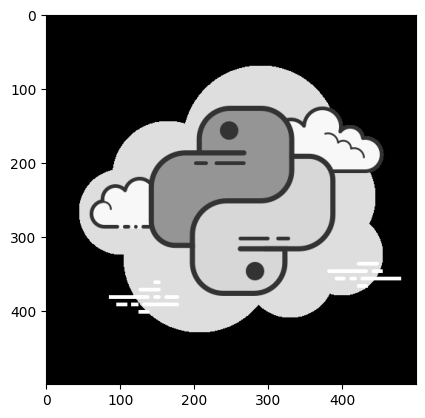

In [7]:
def run():
    encoded = encode(img)
    decoded =decode(encoded)

    plt.imshow(decoded, cmap="gray")

timeit.timeit(run, number=1)